In [85]:
# !conda install -c conda-forge librosa

# !conda install tqdm

import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import utils
reload(utils)
import hyperparams
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
reload(dcttsModel)

<module 'dcttsModel' from '/home/aduriseti/tts/ettts/dcttsModel.py'>

In [86]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [87]:
# params = hyperparams.Hyperparams()
ssrnParams = hyperparams.Hyperparams(sep=1,pad=None,chunk=None)
text2MelParams = hyperparams.Hyperparams(sep=3)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)

# print tunable hyperparams
print('TEXT2MEL HYPERPARAMS',text2MelParams.paramDict)
print('SSRN HYPERPARAMS',ssrnParams.paramDict)
[sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,ssrn)]


TEXT2MEL HYPERPARAMS {'sep': 3, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'sqz': 4, 'pad': 0}
SSRN HYPERPARAMS {'sep': 1, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001}


[7302136, 24991247]

In [88]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A,I):
        b,N,T = A.shape
        assert I.shape == (b,)
        if sum(I):
            W = ch.Tensor([[[np.e**(-(n/N-(t-i)/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)]
                           for i in range(b)])
        else:
            W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()

L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [94]:
nWorkers = 8 if ch.cuda.is_available() else 0
# nWorkers = 4 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1,params=text2MelParams),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)
text2MelParams = hyperparams.Hyperparams(sep=3,pad=2)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)
text2MelOpt = ch.optim.Adam(text2Mel.parameters(),lr=text2MelParams.lr,
                            betas=(text2MelParams.b1,text2MelParams.b2),
                            eps=text2MelParams.eps)

def text2MelLossFun(text2Mel,batch):
    bL,bS,_,bI = batch
    Shat,A = text2Mel(bL,bS)
    melLoss = MelFun(Shat[:,:,:-text2Mel.params.chunk],bS[:,:,text2Mel.params.chunk:])
    attLoss = GAttFun(A,bI)
    return melLoss + attLoss

def text2MelDispFun(text2Mel,batch):
#     bL,bS,bY,bI = batch
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
    print([bL.shape,bS.shape,bY.shape,i.shape])
    print('LOSS:',text2MelLossFun(text2Mel,batch).item())
    Shat,A = text2Mel(bL,bS)
    bL,bS,Shat,A,bY,i = [t[0].cpu().detach().numpy() for t in (bL,bS,Shat,A,bY,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(text2Mel.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(Shat,cmap='gray')
    plt.show()
    plt.imshow(A,cmap='gray')
    plt.show()

In [100]:
text2MelWrapper = utils.ModelWrapper(network=text2Mel,optimizer=text2MelOpt,
                                     lossFun=text2MelLossFun,loader=text2MelLoader,
                                     modelName='text2Mel',dev=dev,dispFun=text2MelDispFun)

INITIALIZED text2Mel WITH HYPERPARAMS {'sep': 3, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'sqz': 4, 'pad': 2}
TOTAL PARAM COUNT 7302136


HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|sqz:4|pad:2
LOADED EPOCH 1, LOSS 1.3028830289840698, BEST LOSS 1.3028830289840698 FROM ./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|sqz:4|pad:2/text2MelBest.pth.tar
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 1.2945419549942017
PAD INDEX 4
TEXT we are now prepared to move into this second phase, on the basis of our experience in the first phaseNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


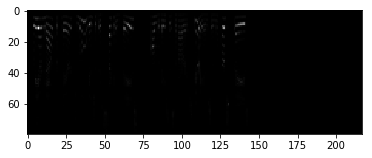

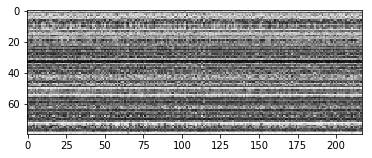

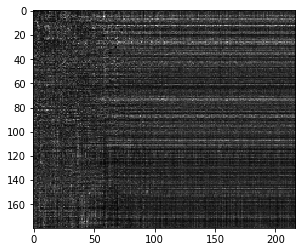

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fc550c77ef0>>
Traceback (most recent call last):
  File "/home/aduriseti/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/aduriseti/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/aduriseti/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/aduriseti/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/aduriseti/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/aduriseti/anaconda3/lib/python3.6/multiprocessing/resource_sha

In [99]:
text2MelWrapper.load()
text2MelWrapper.disp()

In [ ]:
text2MelWrapper.train(numEpochs=100)
text2MelWrapper.save()

EPOCH 0


In [52]:
import datasets
from importlib import reload
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)

text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)

params = text2MelParams
text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev)
else:
    # COLD START - RESET text2Mel
    print('COLD START')
    print('TEXT2MEL HYPERPARAMS',text2MelParams.paramDict)
    text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0
PATH DOES NOT EXIST: ./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0/text2MelBest.pth.tar
PATH DOES NOT EXIST: ./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0/text2MelChkpt.pth.tar
LOADED EPOCH 149, LOSS 0.02688507627584596, BEST LOSS 0.02688507627584596 FROM


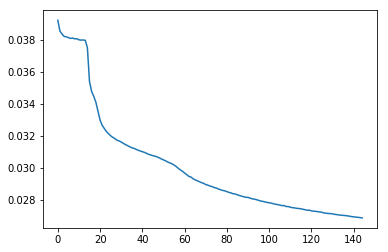

In [53]:
plt.plot(lossHist[5:])

EPOCH 107



epoch 107 total 0.027769413217902182 mel 0.024988310411572456 att 6.434764509322122e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 107, LOSS 0.027769413217902182, BEST LOSS 0.027769413217902182 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


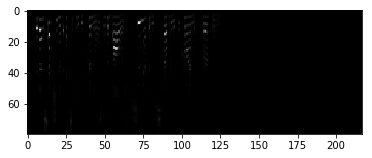

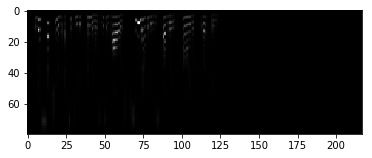

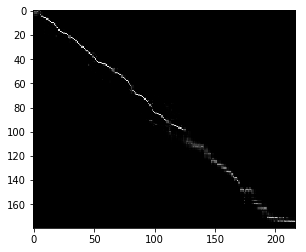

EPOCH 108



epoch 108 total 0.02773864938974825 mel 0.01771450787782669 att 0.00013146415585651994
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 108, LOSS 0.02773864938974825, BEST LOSS 0.02773864938974825 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


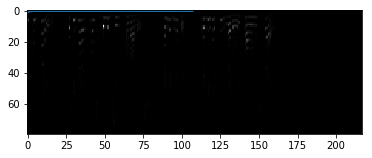

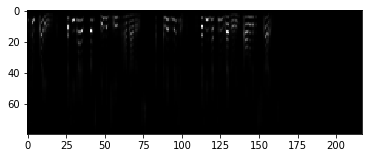

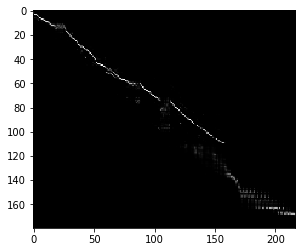

EPOCH 109



epoch 109 total 0.027714882524155857 mel 0.026230372488498688 att 0.00010647907038219273
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 109, LOSS 0.027714882524155857, BEST LOSS 0.027714882524155857 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


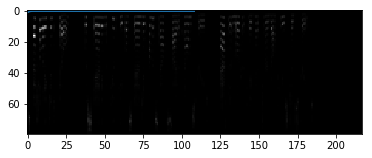

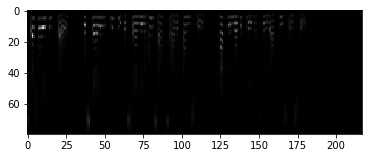

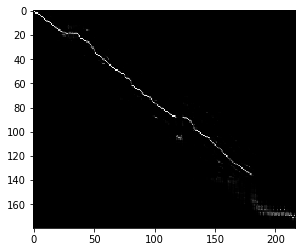

EPOCH 110



epoch 110 total 0.027690149073614112 mel 0.029495133087038994 att 4.375661592348479e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 110, LOSS 0.027690149073614112, BEST LOSS 0.027690149073614112 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


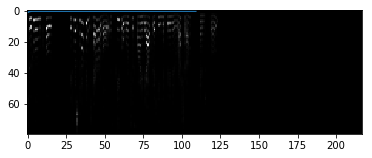

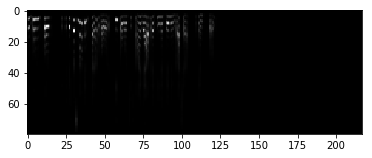

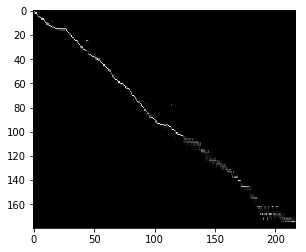

EPOCH 111



epoch 111 total 0.027653001162654428 mel 0.01905214600265026 att 6.446815677918494e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 111, LOSS 0.027653001162654428, BEST LOSS 0.027653001162654428 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


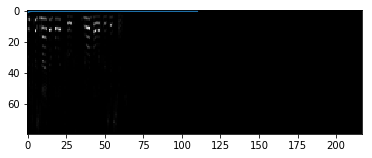

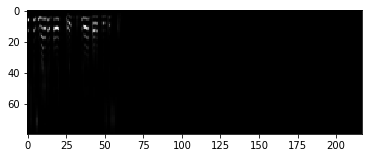

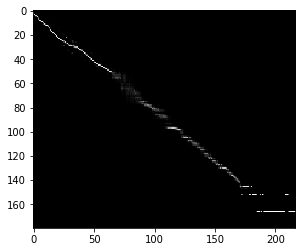

EPOCH 112



epoch 112 total 0.027659227585058604 mel 0.04245764762163162 att 0.00037487485678866506
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 112, LOSS 0.027659227585058604, BEST LOSS 0.027653001162654428 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar']


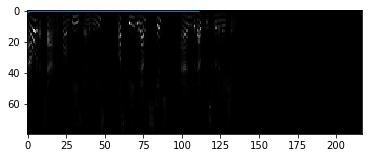

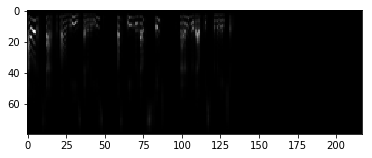

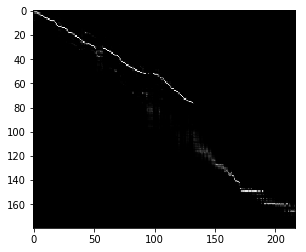

EPOCH 113



epoch 113 total 0.027599045228379877 mel 0.020835550501942635 att 5.1873328629881144e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 113, LOSS 0.027599045228379877, BEST LOSS 0.027599045228379877 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


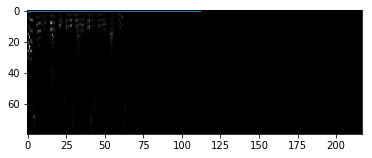

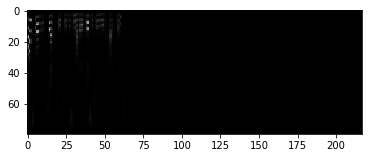

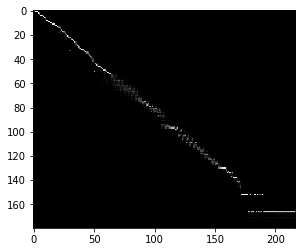

EPOCH 114



epoch 114 total 0.027594565644637862 mel 0.031654875725507736 att 0.00016861184849403799
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 114, LOSS 0.027594565644637862, BEST LOSS 0.027594565644637862 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


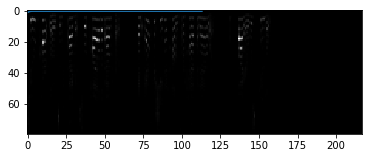

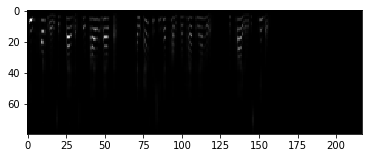

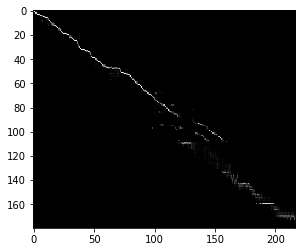

EPOCH 115



epoch 115 total 0.027555651312221343 mel 0.017794227227568626 att 5.720600165659562e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 115, LOSS 0.027555651312221343, BEST LOSS 0.027555651312221343 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


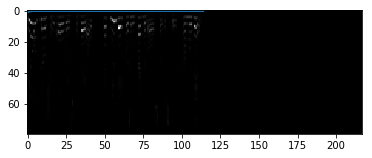

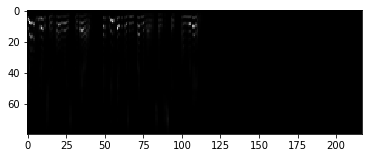

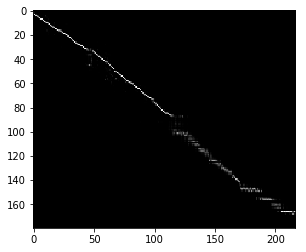

EPOCH 116



epoch 116 total 0.02752548153442678 mel 0.020630471408367157 att 8.047084702411667e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 116, LOSS 0.02752548153442678, BEST LOSS 0.02752548153442678 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


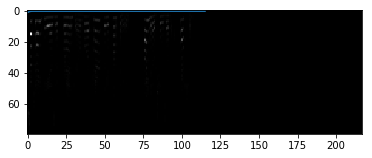

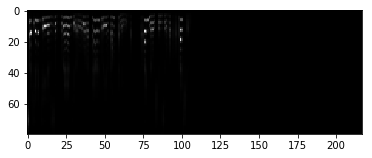

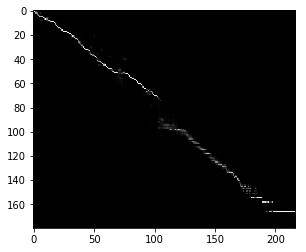

EPOCH 117



epoch 117 total 0.02751081116052706 mel 0.025008702650666237 att 9.355674410471693e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 117, LOSS 0.02751081116052706, BEST LOSS 0.02751081116052706 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


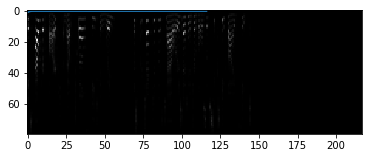

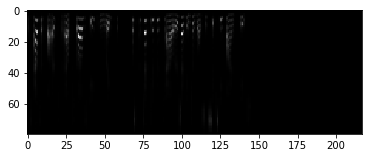

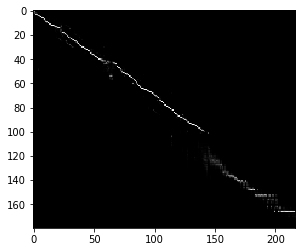

EPOCH 118



epoch 118 total 0.02748471611082109 mel 0.02350820042192936 att 9.350501204608008e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 118, LOSS 0.02748471611082109, BEST LOSS 0.02748471611082109 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


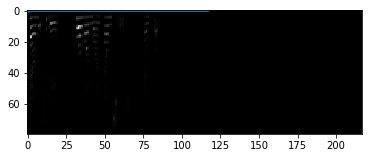

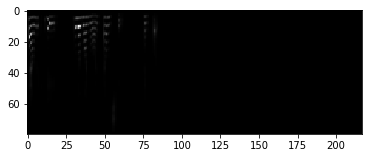

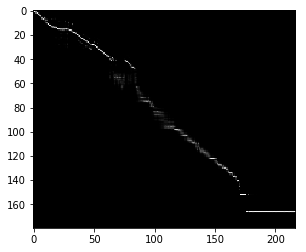

EPOCH 119



epoch 119 total 0.027472303660391873 mel 0.031487781554460526 att 0.00018654826271813363
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 119, LOSS 0.027472303660391873, BEST LOSS 0.027472303660391873 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


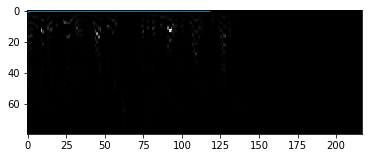

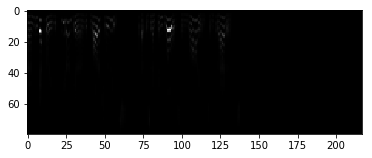

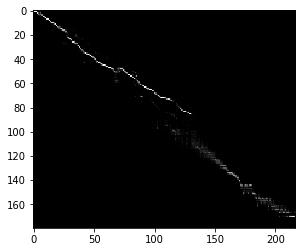

EPOCH 120



epoch 121 total 0.02742500680762885 mel 0.032727815210819244 att 0.0002378396166022867
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 121, LOSS 0.02742500680762885, BEST LOSS 0.02742500680762885 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


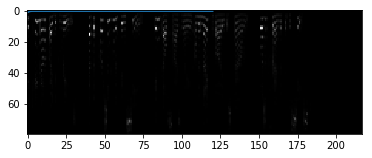

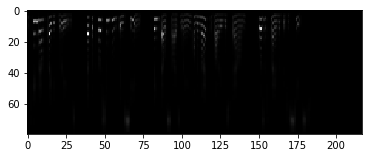

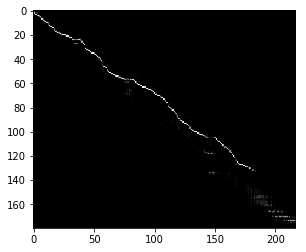

EPOCH 122



epoch 122 total 0.027390461011942643 mel 0.02309698611497879 att 0.00020826826221309602
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 122, LOSS 0.027390461011942643, BEST LOSS 0.027390461011942643 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


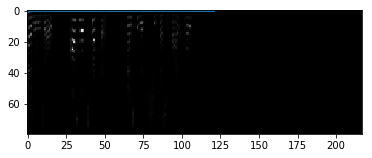

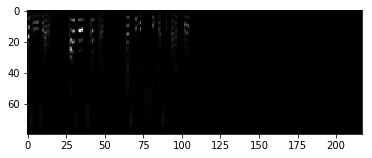

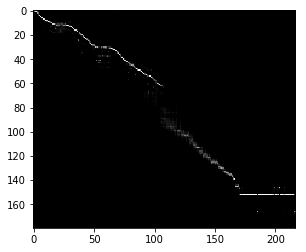

EPOCH 123



epoch 123 total 0.027363902972594126 mel 0.020026322454214096 att 0.00016190344467759132
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 123, LOSS 0.027363902972594126, BEST LOSS 0.027363902972594126 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


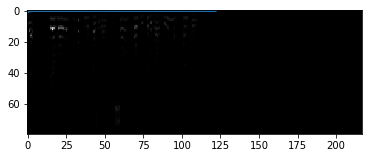

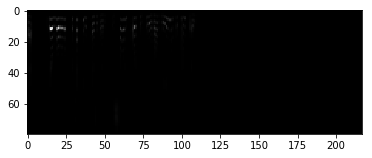

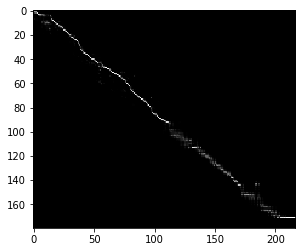

EPOCH 124



epoch 124 total 0.027368886757697632 mel 0.041253477334976196 att 0.00019371460075490177
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 124, LOSS 0.027368886757697632, BEST LOSS 0.027363902972594126 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar']


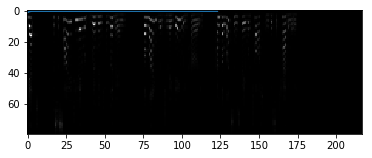

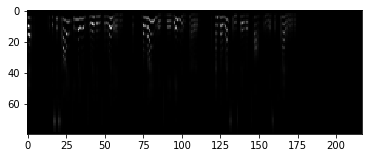

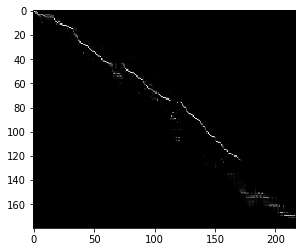

EPOCH 125


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 129 total 0.02725793391521742 mel 0.03126057982444763 att 0.0002029250026680529
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 129, LOSS 0.02725793391521742, BEST LOSS 0.02725793391521742 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


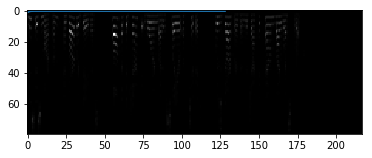

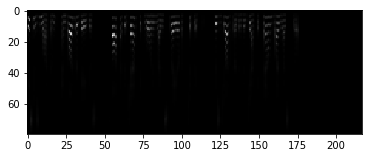

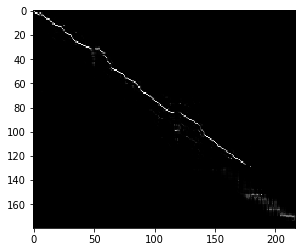

EPOCH 130



epoch 130 total 0.027236788589229333 mel 0.0338582918047905 att 0.0002197329158661887
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 130, LOSS 0.027236788589229333, BEST LOSS 0.027236788589229333 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


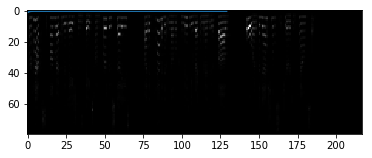

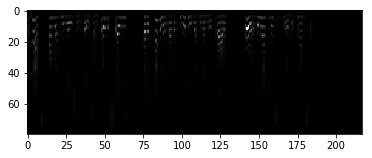

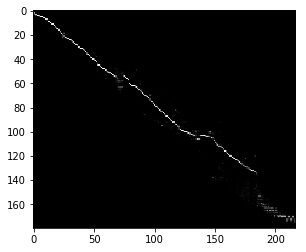

EPOCH 131


In [ ]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,150*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(batchL,batchS,_) in tqdm.tqdm_notebook(enumerate(text2MelLoader)):
        batchL = batchL.to(dev)
        batchS = batchS.to(dev)
        bL = ch.autograd.Variable(batchL)
        bS = ch.autograd.Variable(batchS)
        Shat,A = text2Mel(bL,bS)
        melloss = MelFun(Shat[:,:,:-params.chunk],bS[:,:,params.chunk:])
        attloss = GAttFun(A)
        loss = melloss + attloss
        epochLoss.append(loss.data.item())
        text2MelOpt.zero_grad()
        loss.backward()
        text2MelOpt.step()
#         if step > 10: break
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',lossHist[-1],
      'mel',melloss.data.item(),'att',attloss.data.item())
    if epoch % 1 == 0:
        bestLoss = min(lossHist[-1],bestLoss)
        state = {
            'epoch': epoch,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'modelState': text2Mel.state_dict(),
            'lossHist': lossHist,
            'bestLoss': bestLoss,
            'optimizerState': text2MelOpt.state_dict() 
        }
        utils.saveChkpt(state,model='text2Mel')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [ ]:
import datasets
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)

ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(ssrn,ssrnOpt,'ssrn',dev)
else:
    # COLD START - RESET SSRN
    print('COLD START')
    print('HYPERPARAMS',utils.paramDict)
    ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

In [ ]:
plt.plot(lossHist)


epoch 2 total 0.17387140542268753
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 2, LOSS 0.17387140542268753, BEST LOSS 0.17387140542268753 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


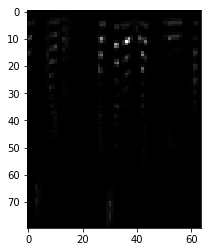

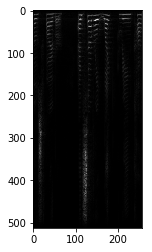

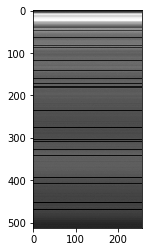

EPOCH 3



epoch 3 total 0.13230819349635892
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 3, LOSS 0.13230819349635892, BEST LOSS 0.13230819349635892 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


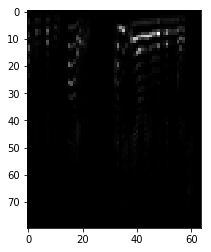

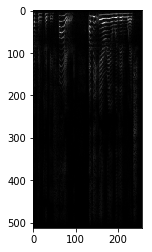

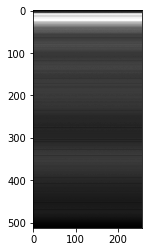

EPOCH 4



epoch 4 total 0.12716792134651497
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 4, LOSS 0.12716792134651497, BEST LOSS 0.12716792134651497 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


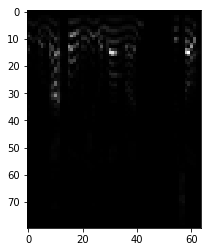

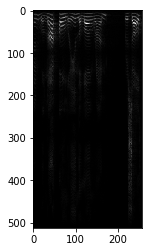

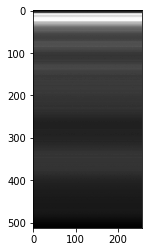

EPOCH 5



epoch 5 total 0.12713798870568846
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 5, LOSS 0.12713798870568846, BEST LOSS 0.12713798870568846 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


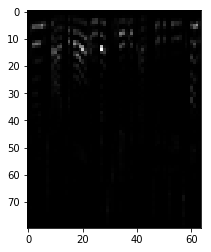

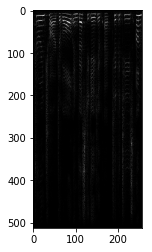

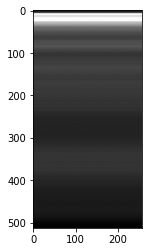

EPOCH 6



epoch 6 total 0.12705405195479963
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 6, LOSS 0.12705405195479963, BEST LOSS 0.12705405195479963 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


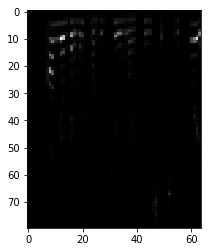

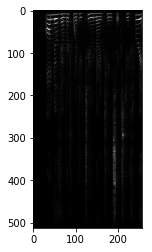

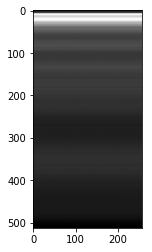

EPOCH 7



epoch 7 total 0.1273351561000098
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 7, LOSS 0.1273351561000098, BEST LOSS 0.12705405195479963 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


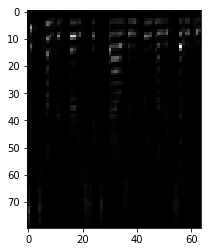

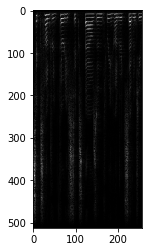

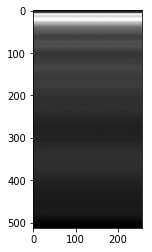

EPOCH 8



epoch 8 total 0.1272349575117453
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 8, LOSS 0.1272349575117453, BEST LOSS 0.12705405195479963 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


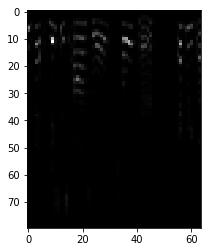

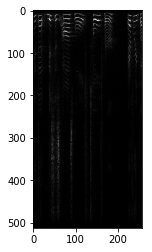

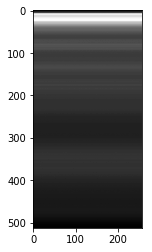

EPOCH 9



epoch 9 total 0.12729148994853248
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 9, LOSS 0.12729148994853248, BEST LOSS 0.12705405195479963 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


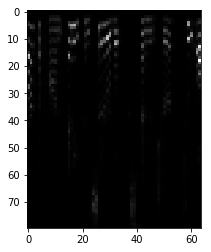

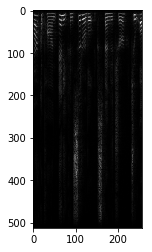

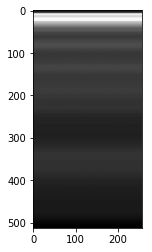

EPOCH 10



epoch 10 total 0.12701706735055837
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 10, LOSS 0.12701706735055837, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


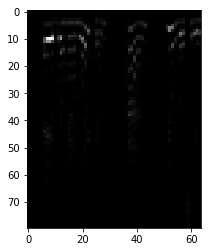

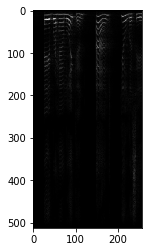

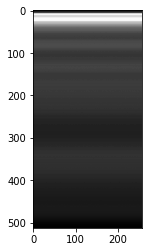

EPOCH 11



epoch 11 total 0.1271951090488861
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 11, LOSS 0.1271951090488861, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


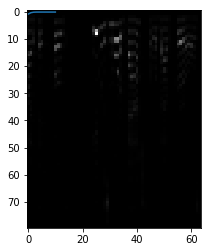

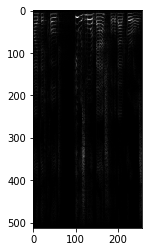

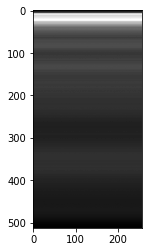

EPOCH 12



epoch 12 total 0.12722844082250523
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 12, LOSS 0.12722844082250523, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


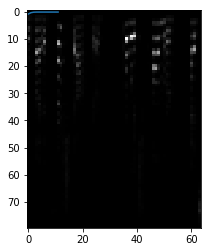

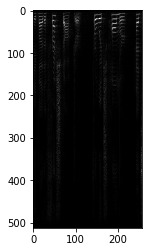

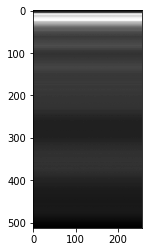

EPOCH 13



epoch 13 total 0.12706331557302333
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 13, LOSS 0.12706331557302333, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


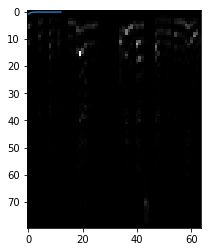

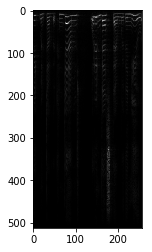

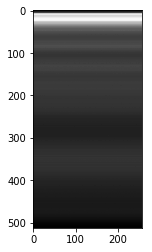

EPOCH 14



epoch 14 total 0.12719500568598063
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 14, LOSS 0.12719500568598063, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


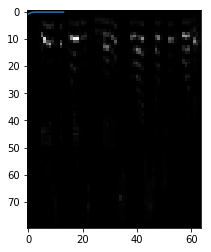

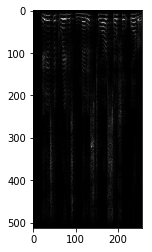

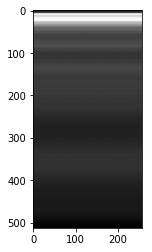

EPOCH 15



epoch 15 total 0.12733614123356876
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 15, LOSS 0.12733614123356876, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


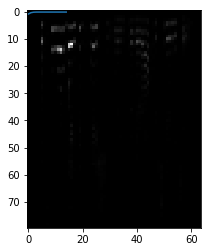

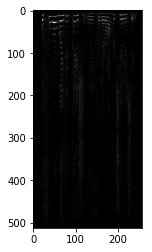

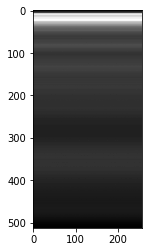

EPOCH 16



epoch 16 total 0.12734707497171502
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 16, LOSS 0.12734707497171502, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


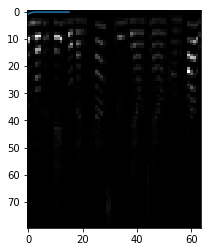

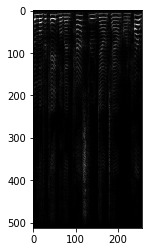

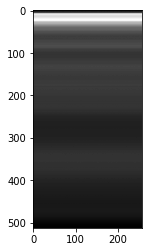

EPOCH 17



epoch 17 total 0.12720665374576157
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 17, LOSS 0.12720665374576157, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


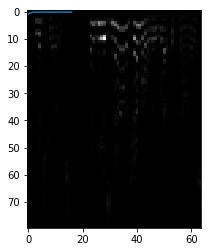

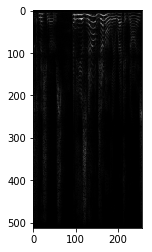

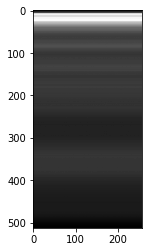

EPOCH 18



epoch 19 total 0.12713579452082294
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 19, LOSS 0.12713579452082294, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


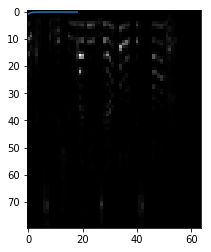

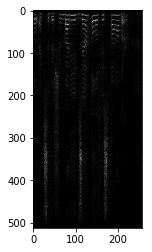

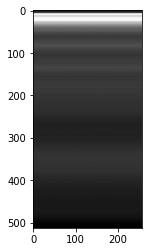

EPOCH 20



epoch 20 total 0.12720647551008124
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 20, LOSS 0.12720647551008124, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


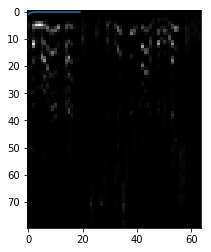

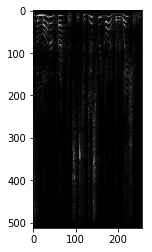

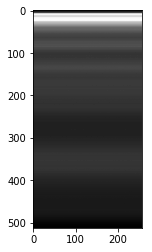

EPOCH 21



epoch 21 total 0.12723620779701134
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 21, LOSS 0.12723620779701134, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


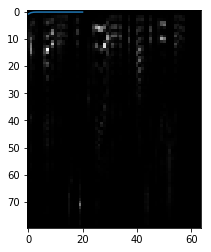

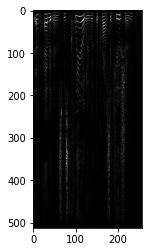

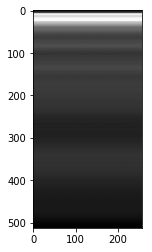

EPOCH 22



epoch 22 total 0.12715815205627412
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 22, LOSS 0.12715815205627412, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


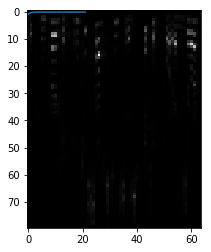

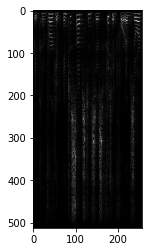

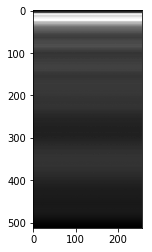

EPOCH 23


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 29 total 0.12714000705685188
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 29, LOSS 0.12714000705685188, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


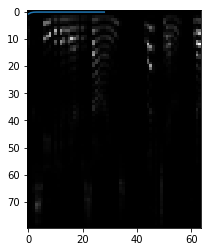

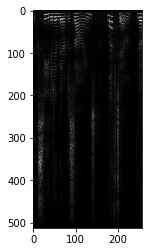

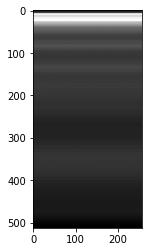

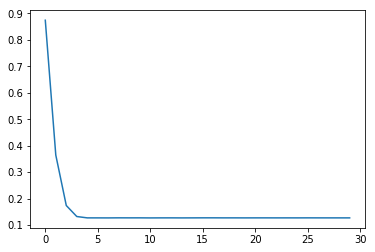

In [11]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,30*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(_,batchS,batchY) in tqdm.tqdm_notebook(enumerate(ssrnLoader)):
        batchS = batchS.to(dev)
        batchY = batchY.to(dev)
        bS = ch.autograd.Variable(batchS)
        bY = ch.autograd.Variable(batchY)
        Yhat = ssrn(bS)
        loss = MelFun(Yhat,bY)
        epochLoss.append(loss.data.item())
        ssrnOpt.zero_grad()
        loss.backward()
        ssrnOpt.step()
#         if step > 1: break
    lossHist.append(np.mean(epochLoss))
    bestLoss = min(bestLoss,lossHist[-1])
    print('epoch',epoch,'total',lossHist[-1])
    if epoch % 1 == 0:
        state = {
            'epoch': epoch,
            'modelState': ssrn.state_dict(),
            'lossHist': lossHist,
            'bestLoss': bestLoss,
            'optimizerState': ssrnOpt.state_dict() 
        }
        utils.saveChkpt(state,model='ssrn')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)